# Generation of artifical sequence data based on Categorical Mixture Models

This notebook is an example of how to generate artifical sequences for the HLA-A gene using our approach based on categorical mixture models.

## Section 1: Setup

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
from gentype import AlleleMM, get_distances
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import sys

Set up Classes:

In [2]:
Database_Name = "Gentype_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Setting the paramaters for our selected allele: HLA-A. For options for ref_name and population_name you can also take a look at the database after fetching.

In [3]:
region_start = 29941260
region_end = 29945884
ref_name = "6" # generally the name of the chromosome
population_name = "ALL"
project_name = "1000GENOMES:phase_3"
allele_args = {'start' : region_start, 'end' : region_end, 'reference_name' : ref_name, 'population' : population_name, 'project' : project_name}

We use store magic to store the values of costly computations (data fetching, model training), so they only have to be done once.

Initialize storable data:

In [4]:
fetched = False
inference_matrix = None
eval_models = None

Restore stored data (remove # to recompute instead of restore respective data):

In [5]:
#%store -d fetched # if you want to refetch the data, uncomment this line
#%store -d inference_matrix # if you want to recompute the inference_matrix, uncomment this line
#%store -d eval_models # if you want to recompute the models, uncomment this line
%store -r

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This only needs to be done once but might take a while.

In [6]:
if not fetched:
    data_manager.fetch_all(region_start, region_end, ref_name, report_progress = True)
fetched = True
%store fetched

Stored 'fetched' (bool)


The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. 

Each row in the matrix represents the variants present in each individual as a bitvector.

In [7]:
if inference_matrix is None:
    inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(**allele_args)
%store inference_matrix 
%store individual_map 
%store variation_map
inference_matrix.shape

Stored 'inference_matrix' (ndarray)
Stored 'individual_map' (dict)
Stored 'variation_map' (dict)


(5008, 438)

Mean number of variations per allele, for HLA-A as expected high.

In [8]:
inference_matrix.sum(axis=1).mean()

91.09704472843451

## Section 3: Splitting test and training Data

In [18]:
#TODO: better splitting method?

split_point = int(len(inference_matrix) - len(inference_matrix)/5)
# if we want to keep using our mapping we need to use the first half for training
inference_matrix_training = inference_matrix[:split_point]
inference_matrix_test = inference_matrix[split_point:]


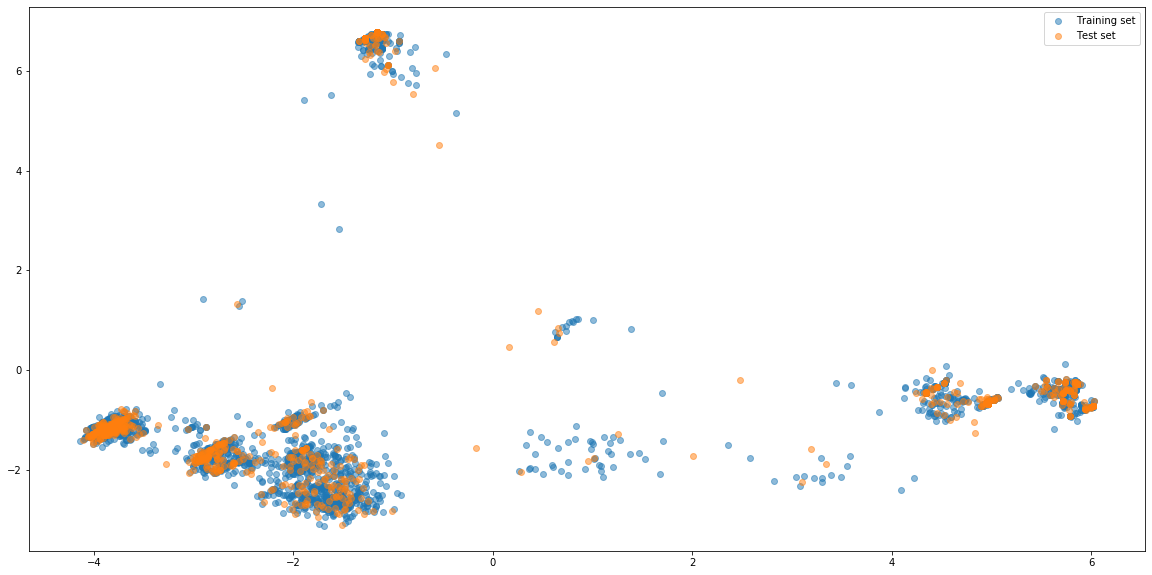

In [19]:
fig, ax = plt.subplots(figsize = (20,10))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()
ax.plot(principalComponents[:split_point,0], principalComponents[:split_point,1], "o", alpha=0.5)
ax.plot(principalComponents[split_point:,0], principalComponents[split_point:,1], "o", alpha=0.5)
ax.legend(["Training set", "Test set"])

## Section 4: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

In [ ]:
number_models = 3
if eval_models is None:
    eval_models = [PiCollapsedNonparametricGibbsSampler(42) for i in range(number_models)]
    for i in range(0, len(eval_models)):
        print("Model {}:".format(i))
        eval_models[i].fit(inference_matrix_training, num_burn_in_steps = 100, delta = 1, alpha = 10**(i - 1))
for i in range(0, len(eval_models)):
    print("Model {} with {} clusters:".format(i, max(eval_models[i].Z)))
    plt.clf()
    plt.plot(eval_models[i].ll_list)
    plt.show()

%store eval_models

Model 0:
Iteration: 1; Current clusters: 8; Likelihood: -1782185.135
Iteration: 2; Current clusters: 8; Likelihood: -1764709.671
Iteration: 3; Current clusters: 8; Likelihood: -1762991.418
Iteration: 4; Current clusters: 8; Likelihood: -1761825.551
Iteration: 5; Current clusters: 7; Likelihood: -1761687.233
Iteration: 6; Current clusters: 7; Likelihood: -1761642.814
Iteration: 7; Current clusters: 7; Likelihood: -1761630.439
Iteration: 8; Current clusters: 7; Likelihood: -1761631.094
Iteration: 9; Current clusters: 7; Likelihood: -1761566.562
Iteration: 10; Current clusters: 7; Likelihood: -1761656.441
Iteration: 11; Current clusters: 7; Likelihood: -1761641.433
Iteration: 12; Current clusters: 7; Likelihood: -1761540.202
Iteration: 13; Current clusters: 7; Likelihood: -1761634.835
Iteration: 14; Current clusters: 7; Likelihood: -1761660.878
Iteration: 15; Current clusters: 7; Likelihood: -1761569.811
Iteration: 16; Current clusters: 7; Likelihood: -1761649.053
Iteration: 17; Current c

May pre select models e.g. according to Aitikens Information Criterion (AIC).

In [12]:
def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood
values = list(map(lambda x: AIC(x), eval_models))
print(values)
best_idx = values.index(min(values))
print("Chose model {}.".format(best_idx))

[2221734.949619845, 2203929.6730219023, 2219090.50733476, 2206330.679973032, 2248999.6639403664]
Chose model 1.


## Section 5: Sequence Generation

The following builds a sequence generator from the parameters which were determined during model training.

We can then sample a set of indices which can be mapped to variant ids.

In [13]:
variant_ranges = data_manager.get_variation_range(**allele_args)
mm = AlleleMM(eval_models[best_idx].Z, eval_models[best_idx].theta, inference_matrix_training, variant_ranges, variation_map)

We can compare the samples to the respective cluster. Here the choice of cluster is equally distributed. In the sampling without specified cluster it is determined based on infered paramters, i.e. in reality some clusters might be much more rare than it may seem here.

In [14]:
number_of_samples = 300
samples = []
descriptions = []
for i in range(number_of_samples):
    characteristic_vector = np.zeros(len(eval_models[best_idx].theta[0]))
    characteristic_vector[mm.sample_variations()] = 1
    samples.append(characteristic_vector)

In order to now actually generate a sequence we first need to convert our bitvector back to variants.

## Section 6: Comparison of distributions

Map each of the test sequences to number of its occurence.

Assign each sample to a test sequence.

In [15]:
avg_assigned_distance, distribution_difference = get_distances(samples, inference_matrix_test)
avg_assigned_distance, distribution_difference

(20.72542372881356, 1.2694142705005766)

In [16]:
for j, model in enumerate(eval_models):
    mm = AlleleMM(model.Z, model.theta, inference_matrix_training, variant_ranges, variation_map)
    samples = []
    descriptions = []
    for i in range(number_of_samples):
        characteristic_vector = np.zeros(len(eval_models[j].theta[0]))
        characteristic_vector[mm.sample_variations()] = 1
        samples.append(characteristic_vector)
    avg_assigned_distance, distribution_difference = get_distances(samples, inference_matrix_test)
    print("Model {} average assigned distance: {}, distribution_difference: {}".format(j, avg_assigned_distance, distribution_difference))
    

Model 0 average assigned distance: 25.686206896551724, distribution_difference: 1.3176144834931238
Model 1 average assigned distance: 21.654237288135594, distribution_difference: 1.2854206602769351
Model 2 average assigned distance: 24.248251748251747, distribution_difference: 1.2981682641108014
Model 3 average assigned distance: 21.68259385665529, distribution_difference: 1.2866027689031325
Model 4 average assigned distance: 20.789830508474576, distribution_difference: 1.2602129925453056


In [17]:
training_avg_assigned_distance, training_distribution_difference = get_distances(inference_matrix_training, inference_matrix_test)
%store training_avg_assigned_distance
%store training_distribution_difference
training_avg_assigned_distance, training_distribution_difference

Stored 'training_avg_assigned_distance' (float)
Stored 'training_distribution_difference' (float64)


(4.036231884057971, 0.7188498402556104)